<a href="https://colab.research.google.com/github/KassemRammal/Python_Code/blob/main/BS_BIF455_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Topological Index Calculator
This notebook calculates different topological indices (Edge Density, Wiener Index, Petitjean Index) from molecular structures.

created by **Kassem Rammal** and **Georgy Zaouk**


In [1]:
!pip install rdkit-pypi
import os
import sys
import requests
from urllib.parse import urlparse
from rdkit import Chem
from rdkit.Chem import AllChem
import networkx as nx
from rdkit.Chem import Draw
from IPython.display import display


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 27.1 MB/s eta 0:00:00



A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.launch_instance()
  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 712, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.11/dist-package

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.launch_instance()
  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 712, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.11/dist-package

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.launch_instance()
  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 712, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.11/dist-package

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.launch_instance()
  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 712, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.11/dist-package

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.launch_instance()
  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 712, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.11/dist-package

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.launch_instance()
  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 712, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.11/dist-package

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.launch_instance()
  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 712, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.11/dist-package

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.launch_instance()
  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 712, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.11/dist-package

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.launch_instance()
  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 712, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.11/dist-package

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.launch_instance()
  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 712, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.11/dist-package

AttributeError: _ARRAY_API not found

### Function: Upload files

In [2]:
from google.colab import files

def upload_files():
    print("\n📁 Upload your .mol/.sdf file(s), or a .zip folder containing them:")
    uploaded = files.upload()
    filenames = list(uploaded.keys())
    # Validate file types immediately after upload
    allowed_exts = ('.mol', '.sdf', '.zip')
    if not all(fname.lower().endswith(allowed_exts) for fname in filenames):
        print("❌ Please upload only .mol, .sdf, or .zip files.")
        sys.exit(1)

    # Handle ZIP folder upload
    if any(fname.endswith('.zip') for fname in filenames):
        import zipfile
        import shutil

        for fname in filenames:
            if fname.endswith('.zip'):
                extract_dir = '/content/uploaded_folder'
                os.makedirs(extract_dir, exist_ok=True)
                with zipfile.ZipFile(fname, 'r') as zip_ref:
                    zip_ref.extractall(extract_dir)
                print(f"✔️ Extracted ZIP contents to {extract_dir}")
                return extract_dir
    elif len(filenames) == 1:
        return filenames[0]
    else:
        # Multiple mol/sdf files uploaded, move to a dedicated folder
        folder_path = '/content/uploaded_files'
        os.makedirs(folder_path, exist_ok=True)
        for fname in filenames:
            os.rename(fname, os.path.join(folder_path, fname))
        return folder_path


### Function: Get file from PUBCHEM ID

In [3]:
def download_from_pubchem(cid, file_format='sdf'):
    sdf_url = f'https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/CID/{cid}/record/SDF?record_type=2d&response_type=save&response_basename=Structure2D_COMPOUND_CID_{cid}'
    name_url = f'https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/{cid}/property/Title/TXT'

    # Download SDF
    sdf_filename = f'{cid}.{file_format}'
    response = requests.get(sdf_url)
    if response.status_code == 200:
        with open(sdf_filename, 'wb') as file:
            file.write(response.content)
        print(f'✔️ Downloaded PubChem CID {cid} as {sdf_filename}')
    else:
        print(f'❌ Failed to fetch compound structure. Status code: {response.status_code}')
        sys.exit(1)

    # Get compound name
    response = requests.get(name_url)
    if response.status_code == 200:
        name = response.text.strip()
        return sdf_filename, cid, name
    else:
        print(f'❌ Failed to fetch compound name. Status code: {response.status_code}')
        return sdf_filename, cid, cid  # fallback


###**Function**: Provide pubchem id or upload file directly

In [4]:
def get_input_path():
    print("Choose your input source:")
    print("1 - Provide a PubChem CID")
    print("2 - Upload one or more .mol or .sdf files, or a ZIP folder of them")

    choice = input("Enter your choice (1 or 2): ").strip()

    if choice == '1':
        cid = input("Enter the CID: ").strip()
        filename, cid, name = download_from_pubchem(cid)
        return filename, 'cid', [(name, cid, Chem.MolFromMolFile(filename))]
    elif choice == '2':
        path = upload_files()
        return path, detect_input_type(path), None
    else:
        print("Invalid choice.")
        sys.exit(1)


### Function: detect_input_type
The **USER** has the freedom to enter a file with a specific type. This function does the following:
  - Identifies the type of the input (whether it's a file, folder, or URL),
  - Takes the appropriate processing steps.

In [5]:
def detect_input_type(input_path):
    if os.path.isdir(input_path):
        return 'mol_folder'
    elif input_path.endswith('.mol'):
        return 'mol_file'
    elif input_path.endswith('.sdf'):
        return 'sdf_file'
    else:
        print('Unsupported file type. Please provide a .mol file, folder, or .sdf file.')
        sys.exit(1)


### Function: get_index_choice

In [6]:
def get_index_choice():
    while True:
        print('Which topological index would you like to calculate?')
        print('1 - Edge Density')
        print('2 - Wiener Index')
        print('3 - Petitjean Index')
        print('4 - All of the above')

        choice = input('Enter your choice (1-4): ').strip()

        options = {
            '1': 'edge',
            '2': 'wiener',
            '3': 'petitjean',
            '4': 'all'
        }

        selected = options.get(choice)
        if selected:
            return selected
        print('Invalid choice. Please select 1, 2, 3, or 4.')


###Function: Read the files and compute necessary indices


**bold text**### Example Usage
The following code demonstrates how to use the functions to select an index, input a file or folder, and determine the file type. It also shows how to combine all functions to compute the selected topological index.

In [7]:
def read_molecules(input_path, input_type):
    molecules = []
    if input_type == 'mol_file':
        mol = Chem.MolFromMolFile(input_path)
        if mol:
            name = mol.GetProp('_Name') if mol.HasProp('_Name') else os.path.basename(input_path)
            cid = name.split('.')[0]  # Try extracting CID from filename
            molecules.append((name, cid, mol))
    elif input_type == 'mol_folder':
        for filename in os.listdir(input_path):
            if filename.lower().endswith('.mol'):
                full_path = os.path.join(input_path, filename)
                mol = Chem.MolFromMolFile(full_path)
                if mol:
                    name = mol.GetProp('_Name') if mol.HasProp('_Name') else filename
                    cid = name.split('.')[0]
                    molecules.append((name, cid, mol))
    elif input_type == 'sdf_file':
        suppl = Chem.SDMolSupplier(input_path)
        for i, mol in enumerate(suppl):
            if mol:
                name = mol.GetProp('_Name') if mol.HasProp('_Name') else f'molecule_{i+1}'
                cid = mol.GetProp('PUBCHEM_COMPOUND_CID') if mol.HasProp('PUBCHEM_COMPOUND_CID') else name
                molecules.append((name, cid, mol))
    return molecules


###Functions: Indices calculation

In [8]:
def mol_to_graph(mol):
    G = nx.Graph()
    for atom in mol.GetAtoms():
        G.add_node(atom.GetIdx())
    for bond in mol.GetBonds():
        G.add_edge(bond.GetBeginAtomIdx(), bond.GetEndAtomIdx())
    return G

In [9]:
def edge_density(G):
    n = G.number_of_nodes()
    m = G.number_of_edges()
    if n <= 1:
        return 0
    return (2 * m) / (n * (n - 1))

In [10]:
def wiener_index(G):
    lengths = dict(nx.all_pairs_shortest_path_length(G))
    total = sum(dist for src in lengths for dist in lengths[src].values())
    return total // 2

In [11]:
def petitjean_index(G):
    if not nx.is_connected(G):
        return None
    eccentricities = nx.eccentricity(G)
    diameter = max(eccentricities.values())
    radius = min(eccentricities.values())
    if diameter == 0:
        return 0
    return (diameter - radius) / diameter

In [12]:
def calculate_indices(molecules, index_choice):
    for name, cid, mol in molecules:
        G = mol_to_graph(mol)

        print(f'\n{name} (PubChem CID: {cid}):')
        if index_choice in ('edge', 'all'):
            print(f'  Edge Density: {edge_density(G):.4f}')
        if index_choice in ('wiener', 'all'):
            print(f'  Wiener Index: {wiener_index(G)}')
        if index_choice in ('petitjean', 'all'):
            pj = petitjean_index(G)
            if pj is not None:
                print(f'  Petitjean Index: {pj:.4f}')
            else:
                print('  Petitjean Index: Cannot be computed (molecule may be disconnected)')

        # Display the 2D structure
        display(Draw.MolToImage(mol, size=(300, 300)))


###MAIN

Additional ideas / Things to fix
1. retry every possibility (one mol, one sdf, one sdf with many comp, one homo zip, one hetero zip, multiple files uploaded)
2. add a bit more in the output maybe a link to the pubchem page
3. fix a bit the output to make it prettier

Choose your input source:
1 - Provide a PubChem CID
2 - Upload one or more .mol or .sdf files, or a ZIP folder of them
Enter your choice (1 or 2): 1
Enter the CID: 11364421
✔️ Downloaded PubChem CID 11364421 as 11364421.sdf
Which topological index would you like to calculate?
1 - Edge Density
2 - Wiener Index
3 - Petitjean Index
4 - All of the above
Enter your choice (1-4): 5
Invalid choice. Please select 1, 2, 3, or 4.
Which topological index would you like to calculate?
1 - Edge Density
2 - Wiener Index
3 - Petitjean Index
4 - All of the above
Enter your choice (1-4): 4

Bi-2536 (PubChem CID: 11364421):
  Edge Density: 0.0597
  Wiener Index: 5040
  Petitjean Index: 0.5000


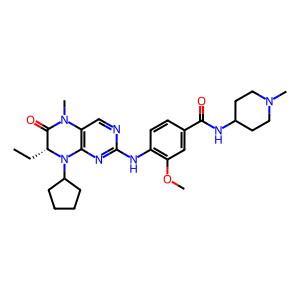

In [13]:
def main():
    input_path, input_type, cid_mol_list = get_input_path()
    index_choice = get_index_choice()

    if cid_mol_list:  # from PubChem
        molecules = cid_mol_list
    else:  # from file or folder
        molecules = read_molecules(input_path, input_type)

    calculate_indices(molecules, index_choice)

main()